In [1]:
!pip install git+https://github.com/ficstamas/FateML.git
!pip install --upgrade scikit-learn~=1.2.1

import matplotlib.pyplot as plt
%matplotlib inline

  Cloning https://github.com/ficstamas/FateML.git to c:\users\ftkni\appdata\local\temp\pip-req-build-r5c44pcj
  Resolved https://github.com/ficstamas/FateML.git to commit 102e9271658d9683ec19811fdbb5cbccd8db118d
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'


  Running command git clone --filter=blob:none --quiet https://github.com/ficstamas/FateML.git 'C:\Users\ftkni\AppData\Local\Temp\pip-req-build-r5c44pcj'


# Model-Agnostic interpretation and explonation

So far, we have looked at intrinsically interpretable models. These models provide insight into their decision-making process and designed to be easily understood by humans through visual representation. The interpretation methods are usually model specific and can not be used among different architectures.


On the otherhand, __model-agnostic methods seprate the interpretation from the machine learning model__, making it flexible to use and allowing the user to compare different types of models. There are 3 desired aspects for an agnostic method:
- __Model flexibility__, which means it can work with any machine learning model. (e.g. linear regression, random forests, neural models)
- __Explanation flexibility__, which means it is not limited to one type fo explanation. (e.g. linear formulas, graphical explanation)
- __Representation flexibility__, which means it can handle different type of features. (e.g. numerical, categorical, time series, words)


Model-agnostic methods can be differentiated into:
- __local methods__, which explain individual predictions, and
- __global methods__, which explain the effect of features on predictions on average

# Global Methods

## Partial Dependence Plots (PDP)

Partial dependence plots (PDP) show the dependence between the target response and a set of input features of interest, marginalizing over the values of all other input features. Intuitively, we can interpret the partial dependence as the expected target response as a function of the input features of interest.

The partial dependence function for regression is defined as:
$$F(x_s)=\frac{1}{n}\sum^n_{i=1}f(x_s, x_c),$$
where $x_s$ contains the perturbed feature values (usually for 1 or 2 features) and $x_c$ defines the real (unchanged) features.

['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
['setosa' 'versicolor' 'virginica']


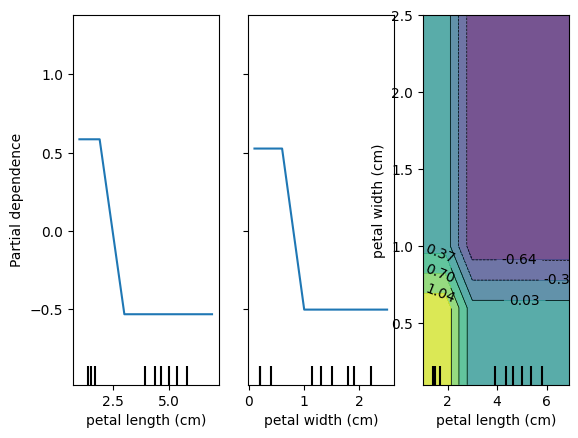

In [2]:
from sklearn.datasets import load_iris
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.inspection import PartialDependenceDisplay

iris = load_iris(as_frame=True)
mc_clf = GradientBoostingClassifier(n_estimators=10, max_depth=1).fit(iris.data, iris.target)
features = ['petal length (cm)', 'petal width (cm)', ('petal length (cm)', 'petal width (cm)')]

print(iris.feature_names)
print(iris.target_names)

PartialDependenceDisplay.from_estimator(mc_clf, iris['data'], features, target=0)

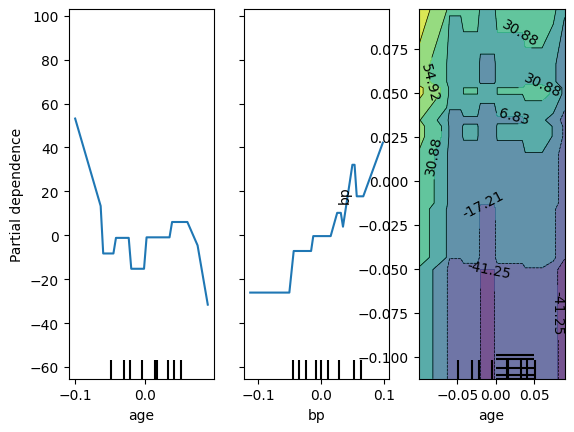

In [13]:
from fateml.data import load_dataset
from sklearn.ensemble import GradientBoostingRegressor

diabetes = load_dataset("diabetes", standardize=False, statsmodels_format=False)
clf = GradientBoostingRegressor(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0).fit(diabetes.train_x, diabetes.train_y.values.ravel())
features = ['age', 'bp', ('age', 'bp')]

PartialDependenceDisplay.from_estimator(clf, diabetes.dev_x, features)